In [15]:
from shapely.geometry import Point
import pandas as pd
import numpy as np
import geopandas as gpd
import matplotlib.pyplot as plt
import seaborn as sns
import folium
from folium.plugins import MarkerCluster, HeatMap, HeatMapWithTime
import ipywidgets as widgets
from IPython.display import HTML, display
from collections import defaultdict

In [2]:
eq_table = pd.read_csv('../Data/04_deadly_eq_mag_cleaned.csv', index_col=False)

In [43]:
eq_table

,origin (utc),present-day country and link to wikipedia article,lat,long,depth (km),magnitude,secondary effects,pde shaking deaths,pde total deaths,utsu total deaths,em-dat total deaths,other source deaths,deats,deaths,original_magnitude,original_magnitude_scale,country
0,1900-05-11 17:23,Japan,38.700,141.100,5,7.0 MJMA,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,7.0,MJMA,Japan
1,1900-07-12 06:25,Turkey,40.300,43.100,NaN,5.9 Muk,NaN,NaN,NaN,140.0,NaN,NaN,140.0,140.0,5.9,Muk,Turkey
2,1900-10-29 09:11,Venezuela,11.000,-66.000,0,7.7 Mw,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,7.7,Mw,Venezuela
3,1901-02-15 00:00,China,26.000,100.100,0,6.5 Ms,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,6.5,Ms,China
4,1901-03-31 07:11,Bulgaria,43.400,28.700,NaN,6.4 Muk,NaN,NaN,NaN,4.0,NaN,NaN,4.0,4.0,6.4,Muk,Bulgaria
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1335,2011-03-24 20:25,Burma (see 2011 Burma earthquake),NaN,NaN,NaN,6.8 Mw,NaN,NaN,NaN,NaN,NaN,150.0,150.0,150.0,6.8,Mw,Burma (see 2011 Burma earthquake)
1336,2011-04-07 14:32,Japan (see April 2011 Miyagi earthquake),38.2,140.0,66.0,7.1 Mw,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,7.1,Mw,Japan (see April 2011 Miyagi earthquake)
1337,2011-09-18 12:40,India (see 2011 Sikkim earthquake),27.723,88.064,19.7,6.9 Mw,L,NaN,NaN,NaN,NaN,111.0,111.0,111.0,6.9,Mw,India (see 2011 Sikkim earthquake)
1338,2011-09-23 10:41,Turkey (see 2011 Van earthquake),38.6,43.5,7.2,7.1 Mw,NaN,NaN,NaN,NaN,NaN,601.0,601.0,601.0,7.1,Mw,Turkey (see 2011 Van earthquake)


In [49]:
eq_table['origin (utc)'] = pd.to_datetime(eq_table['origin (utc)'])

In [51]:
eq_table['year'] = eq_table['origin (utc)'].dt.year

In [27]:
eq_table['present-day country and link to wikipedia article']

0                                          Japan
1                                         Turkey
2                                      Venezuela
3                                          China
4                                       Bulgaria
                          ...                   
1335           Burma (see 2011 Burma earthquake)
1336    Japan (see April 2011 Miyagi earthquake)
1337          India (see 2011 Sikkim earthquake)
1338            Turkey (see 2011 Van earthquake)
1339           Indonesia (see Lombok earthquake)
Name: present-day country and link to wikipedia article, Length: 1340, dtype: object

In [28]:
eq_table['country'] = eq_table['present-day country and link to wikipedia article'].apply(lambda x: x.split(' ()', 1)[0])

In [29]:
corr = eq_table.corr()

In [30]:
mask = np.triu(np.ones_like(corr, dtype=bool))

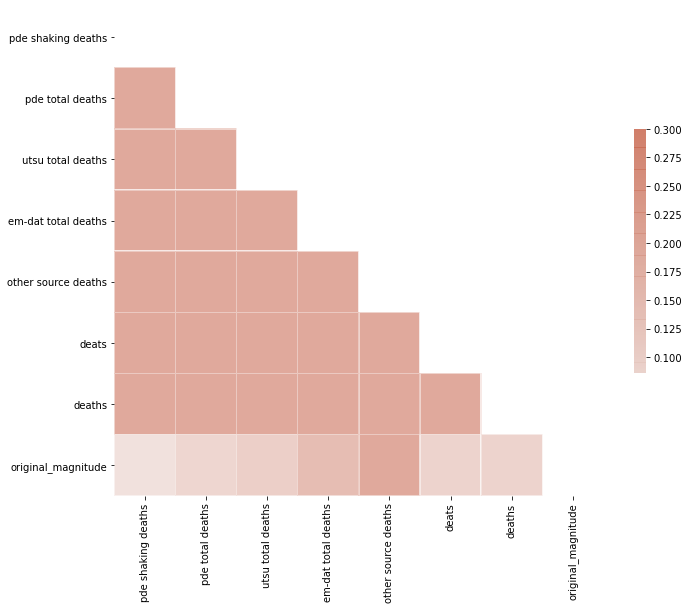

In [37]:
f, ax = plt.subplots(figsize=(11, 9))
cmap = sns.diverging_palette(230, 20, as_cmap=True)
sns.heatmap(corr, mask=mask, cmap=cmap, vmax=.3, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5},  alpha=.5);

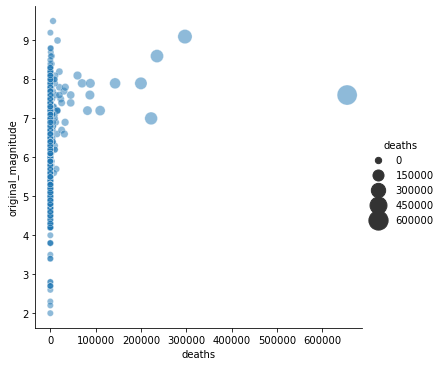

In [34]:
sns.relplot(x='deaths', y='original_magnitude', data=eq_table, size='deaths', sizes=(40, 400), alpha=.5, palette="muted",);

# Doesn't appear to be a correlation between magnitude and deaths on overall

In [73]:
un_pop = pd.read_csv(r"../data/UNdata_Export_20201023_020140725.csv")

In [74]:
un_pop.columns

Index(['Country or Area', 'Year(s)', 'Variant', 'Value'], dtype='object')

In [75]:
un_pop_medium = un_pop[un_pop['Variant'] =='Medium']

In [78]:
un_pop_medium = un_pop_medium.rename(columns = {"Value": "population", "Year(s)": "year"})

In [79]:
un_pop_medium['country_join'] = un_pop_medium['Country or Area'].str.lower()

In [80]:
eq_table['country_join'] = eq_table['country'].str.lower()

In [82]:
eq_table_pop = eq_table.merge(un_pop_medium, on=['country_join', 'year'])

In [84]:
eq_table_pop[['deaths', 'population']].corr()

,deaths,population
deaths,1.000000,-0.041335
population,-0.041335,1.000000


# in the matchable subset, there is a negative correlation with population

- Download GDP data as CSV data from http://data.un.org/Data.aspx?q=gdp&d=SNAAMA&f=grID%3a101%3bcurrID%3aUSD%3bpcFlag%3a1
- Rename file to un_per_capita_gdp.csv

In [107]:
un_gdp = pd.read_csv(r"../data/un_per_capita_gdp.csv", skipfooter=2)

<ipython-input-107-bfa48b5609f6>:1: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support skipfooter; you can avoid this warning by specifying engine='python'.
  un_gdp = pd.read_csv(r"../data/un_per_capita_gdp.csv", skipfooter=2)


In [108]:
un_gdp = un_gdp.rename(columns = {"Value": "gdp", "Country or Area": "country", "Year": "year"})

In [113]:
un_gdp = un_gdp[un_gdp['Item']=='Gross Domestic Product (GDP)']

In [114]:
un_gdp['country_join'] = un_gdp['country'].str.lower()

In [115]:
un_gdp.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 9869 entries, 0 to 9868
Data columns (total 5 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   country       9869 non-null   object 
 1   year          9869 non-null   int64  
 2   Item          9869 non-null   object 
 3   gdp           9869 non-null   float64
 4   country_join  9869 non-null   object 
dtypes: float64(1), int64(1), object(3)
memory usage: 462.6+ KB


In [117]:
eq_table_pop_gdp = eq_table_pop.merge(un_gdp, on=['country_join', 'year'] )

In [118]:
eq_table_pop_gdp[['deaths', 'gdp']].corr()

,deaths,gdp
deaths,1.000000,-0.035793
gdp,-0.035793,1.000000


<AxesSubplot:xlabel='deaths', ylabel='gdp'>

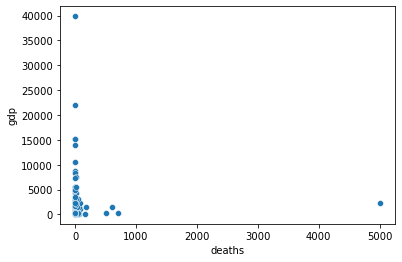

In [119]:
sns.scatterplot(x='deaths', y='gdp', data=eq_table_pop_gdp[['deaths', 'gdp']])

In [124]:
eq_table_pop_gdp['log_deaths'] = np.log(eq_table_pop_gdp['deaths'])

In [125]:
eq_table_pop_gdp

,origin (utc),present-day country and link to wikipedia article,lat,long,depth (km),magnitude,secondary effects,pde shaking deaths,pde total deaths,utsu total deaths,...,country_x,year,country_join,Country or Area,Variant,population,country_y,Item,gdp,log_deaths
0,1970-07-31 17:08:00,Colombia,-1.486,-72.563,644.6,8.0 Muk,NaN,1.0,1.0,1.0,...,Colombia,1970,colombia,Colombia,Medium,21480.065,Colombia,Gross Domestic Product (GDP),470.040032,0.000000
1,1971-06-17 21:00:00,Chile,-25.423,-69.052,90.1,7.2 mb,NaN,1.0,1.0,1.0,...,Chile,1971,chile,Chile,Medium,9942.727,Chile,Gross Domestic Product (GDP),1165.450214,0.000000
2,1971-07-09 03:03:00,Chile,-32.558,-71.085,59,7.8 Mw,T,83.0,83.0,83.0,...,Chile,1971,chile,Chile,Medium,9942.727,Chile,Gross Domestic Product (GDP),1165.450214,4.442651
3,1972-06-24 15:29:00,Afghanistan,36.255,69.684,31.1,6.1 Ms,NaN,11.0,11.0,11.0,...,Afghanistan,1972,afghanistan,Afghanistan,Medium,11791.215,Afghanistan,Gross Domestic Product (GDP),135.317309,2.397895
4,1973-04-14 08:34:00,Costa Rica,10.673,-84.860,30.3,6.5 Ms,NaN,26.0,26.0,26.0,...,Costa Rica,1973,costa rica,Costa Rica,Medium,1992.514,Costa Rica,Gross Domestic Product (GDP),975.802729,3.258097
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
99,2007-11-14 15:40:00,Chile,-22.247,-69.890,40,7.7 Mw,T,2.0,2.0,NaN,...,Chile,2007,chile,Chile,Medium,16530.195,Chile,Gross Domestic Product (GDP),10502.355190,0.693147
100,2007-12-09 02:03:00,Brazil,-15.048,-44.231,10,4.9 mb,NaN,1.0,1.0,NaN,...,Brazil,2007,brazil,Brazil,Medium,190130.443,Brazil,Gross Domestic Product (GDP),7348.188040,0.000000
101,2008-01-09 22:24:00,Algeria,35.616,-0.570,10,4.6 Mb,NaN,1.0,1.0,NaN,...,Algeria,2008,algeria,Algeria,Medium,34730.608,Algeria,Gross Domestic Product (GDP),4923.630825,0.000000
102,2008-06-06 20:02:00,Algeria,35.883,-0.658,4,5.5 Mw,NaN,0.0,1.0,NaN,...,Algeria,2008,algeria,Algeria,Medium,34730.608,Algeria,Gross Domestic Product (GDP),4923.630825,0.000000


<AxesSubplot:xlabel='log_deaths', ylabel='gdp'>

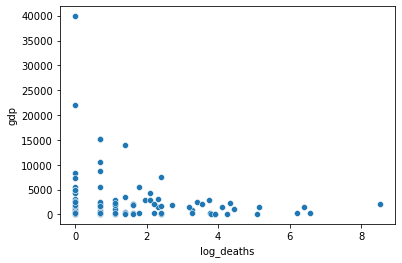

In [126]:
sns.scatterplot(x='log_deaths', y='gdp', data=eq_table_pop_gdp[['log_deaths', 'gdp']])